# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
!pip install matplotlib==2.0.2

    100% |████████████████████████████████| 14.6MB 50kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


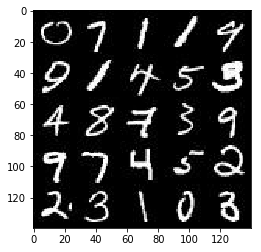

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

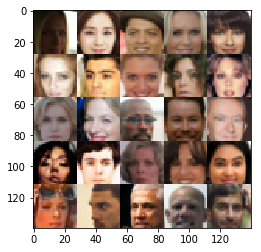

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input_images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name = 'tensor_z_data')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')   
    
    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.06): #alpha 0.0001
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #initializer = tf.contrib.layers.xavier_initializer()
        ##d_relu1 = tf.maximum(d1*alpha, d1)
        #d_drop1 = tf.layers.dropout(d_relu1,rate=dropout)
        
        #d2 = tf.layers.conv2d(d_relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #d_bn2 = tf.layers.batch_normalization(d2, training=True)
        #d_relu2 = tf.maximum(d_bn2*alpha, d_bn2)
        #d_drop = tf.layers.dropout(d_relu2,rate=dropout)
        
        #d3 = tf.layers.conv2d(d_relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #d_bn3 = tf.layers.batch_normalization(d3, training=True)
        #d_relu3 = tf.maximum(d_bn3*alpha, d_bn3)
        
        #flatten = tf.reshape(d_relu3, (-1,4*4*256))
        #flatten = tf.contrib.layers.flatten(d_relu3)
        #logits = tf.layers.dense(flatten, 1)
        #out = tf.sigmoid(logits)
        
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.06): #alpha 0.0001
     with tf.variable_scope('generator', reuse=not is_train):
        #dropout = 0.1
        # First fully connected layer
        #g_initializer = tf.contrib.layers.xavier_initializer()
        #g_full = tf.layers.dense(z, 4*4*1024)
        #g_full = tf.reshape(g_full, (-1, 4, 4, 1024))
        #g_full = tf.layers.batch_normalization(g_full, training=is_train)
        #g_full = tf.maximum(alpha * g_full, g_full)
        # 4x4x1024 now
        
        #g_full = tf.layers.dense(z, 4*4*512)
        #g_full = tf.reshape(g_full, (-1, 4, 4, 512))
        #g_full = tf.layers.batch_normalization(g_full, training=is_train)
        #g_full = tf.maximum(alpha * g_full, g_full)
        
        #g1 = tf.layers.conv2d_transpose(g_full, 512, 4, strides=1, kernel_initializer=g_initializer)
        #g1 = tf.layers.batch_normalization(g1, training=is_train)
        #g1 = tf.maximum(alpha * g1, g1)
        #g1_drop = tf.layers.dropout(g1,rate=dropout)
        # 7x7x512
        
       # g2 = tf.layers.conv2d_transpose(g_full, 256, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
       # bn_2 = tf.layers.batch_normalization(g2, training=is_train)
       # g2_relu = tf.maximum(alpha * bn_2, bn_2)
        #g2_drop = tf.layers.dropout(g2,rate=dropout)
        # 7x7x256 now
        
        #g3 = tf.layers.conv2d_transpose(g2_relu, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
       # bn_3 = tf.layers.batch_normalization(g3, training=is_train)
        #g3_relu = tf.maximum(alpha * bn_3, bn_3)
        # 14x14x128 now
        
        #g4 = tf.layers.conv2d_transpose(g3_relu, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #bn_4 = tf.layers.batch_normalization(g4, training=is_train)
        #g4_relu = tf.maximum(alpha * bn_4, bn_4)
        
        # Output layer
        #logits = tf.layers.conv2d_transpose(g3_relu, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        #out = tf.tanh(logits)
        
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2): #0.06#alpha 0.0001, 0.08
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(#add smoothing
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    images_grid = np.asarray(images_grid, dtype=np.uint8)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    real_images, z_data, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_images, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_loss_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_images: batch_images, z_data: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_data: batch_z, real_images: batch_images, lr:learning_rate})
                
                if steps % print_loss_every == 0:
                    train_loss_d = d_loss.eval({z_data: batch_z, real_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: batch_z})
                    
                    print("Step {}/{}...".format(steps, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 24, z_data, data_shape[3], data_image_mode)
                    
                   
               
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 50/1... Discriminator Loss: 0.5282... Generator Loss: 7.0650
Step 100/1... Discriminator Loss: 0.7560... Generator Loss: 1.4452


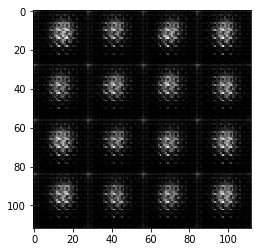

Step 150/1... Discriminator Loss: 0.4738... Generator Loss: 2.8794
Step 200/1... Discriminator Loss: 0.8429... Generator Loss: 3.0456


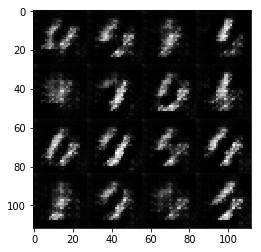

Step 250/1... Discriminator Loss: 0.7610... Generator Loss: 1.3564
Step 300/1... Discriminator Loss: 1.1328... Generator Loss: 2.5101


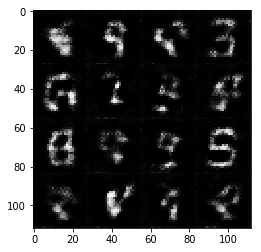

Step 350/1... Discriminator Loss: 0.8603... Generator Loss: 1.4070
Step 400/1... Discriminator Loss: 0.8208... Generator Loss: 1.6533


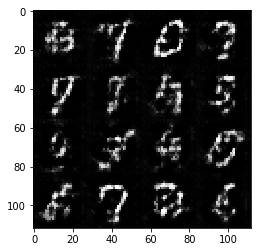

Step 450/1... Discriminator Loss: 0.9542... Generator Loss: 1.5523
Step 500/2... Discriminator Loss: 0.9524... Generator Loss: 0.9925


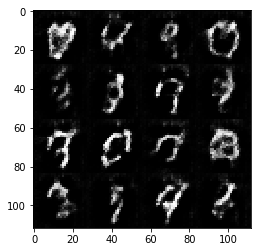

Step 550/2... Discriminator Loss: 0.8569... Generator Loss: 1.2070
Step 600/2... Discriminator Loss: 0.8526... Generator Loss: 1.5988


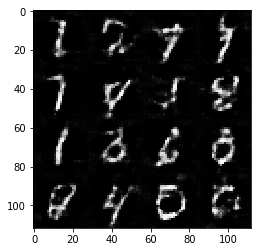

Step 650/2... Discriminator Loss: 1.1622... Generator Loss: 2.1962
Step 700/2... Discriminator Loss: 1.0555... Generator Loss: 0.8868


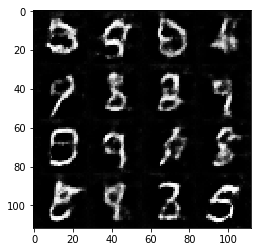

Step 750/2... Discriminator Loss: 1.2143... Generator Loss: 0.6111
Step 800/2... Discriminator Loss: 0.9976... Generator Loss: 1.5129


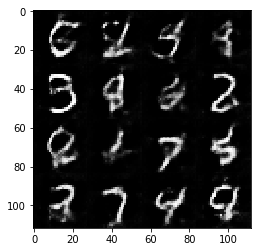

Step 850/2... Discriminator Loss: 0.9683... Generator Loss: 0.9437
Step 900/2... Discriminator Loss: 1.1205... Generator Loss: 0.6992


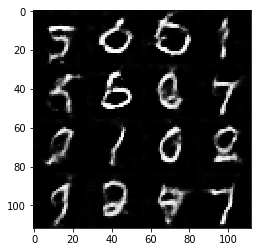

In [31]:
batch_size =  128
z_dim = 100
learning_rate = 0.0002#0.001#0.0002#0.0004#0.0002#0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 50/1... Discriminator Loss: 1.3942... Generator Loss: 0.7354
Step 100/1... Discriminator Loss: 1.4779... Generator Loss: 0.5924


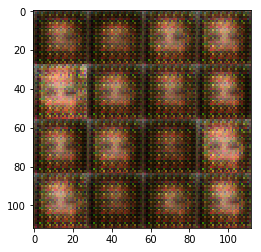

Step 150/1... Discriminator Loss: 1.4418... Generator Loss: 0.8085
Step 200/1... Discriminator Loss: 1.6188... Generator Loss: 1.7113


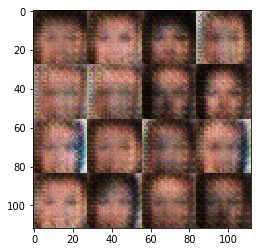

Step 250/1... Discriminator Loss: 1.4073... Generator Loss: 0.7623
Step 300/1... Discriminator Loss: 1.4646... Generator Loss: 0.5993


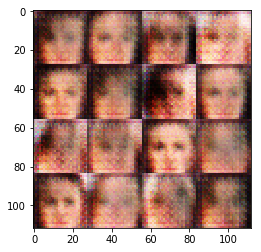

Step 350/1... Discriminator Loss: 1.3191... Generator Loss: 1.0420
Step 400/1... Discriminator Loss: 2.0352... Generator Loss: 2.7537


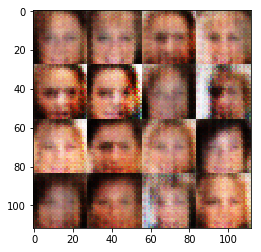

Step 450/1... Discriminator Loss: 1.4000... Generator Loss: 0.5190
Step 500/1... Discriminator Loss: 1.1987... Generator Loss: 1.6831


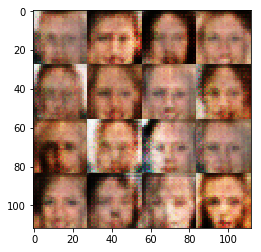

Step 550/1... Discriminator Loss: 0.8636... Generator Loss: 1.8951
Step 600/1... Discriminator Loss: 1.3664... Generator Loss: 1.0510


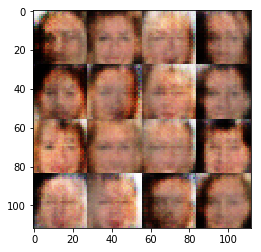

Step 650/1... Discriminator Loss: 1.5036... Generator Loss: 0.6910
Step 700/1... Discriminator Loss: 0.8790... Generator Loss: 1.4305


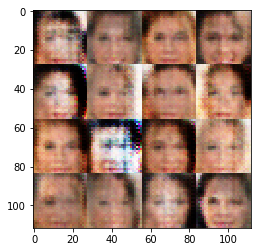

Step 750/1... Discriminator Loss: 0.9885... Generator Loss: 1.6562
Step 800/1... Discriminator Loss: 1.2369... Generator Loss: 1.5657


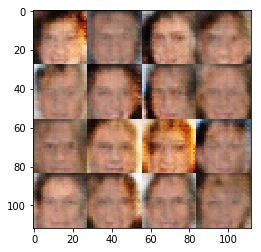

Step 850/1... Discriminator Loss: 1.3535... Generator Loss: 0.8382
Step 900/1... Discriminator Loss: 1.3176... Generator Loss: 0.6590


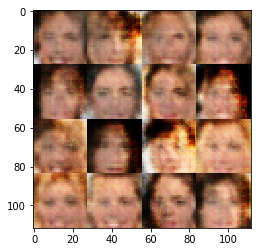

Step 950/1... Discriminator Loss: 1.3695... Generator Loss: 0.5746
Step 1000/1... Discriminator Loss: 1.3046... Generator Loss: 0.6604


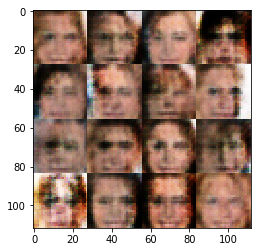

Step 1050/1... Discriminator Loss: 1.4304... Generator Loss: 1.0836
Step 1100/1... Discriminator Loss: 1.4161... Generator Loss: 1.0936


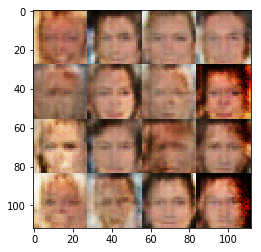

Step 1150/1... Discriminator Loss: 1.1972... Generator Loss: 1.3854
Step 1200/1... Discriminator Loss: 1.3776... Generator Loss: 0.6367


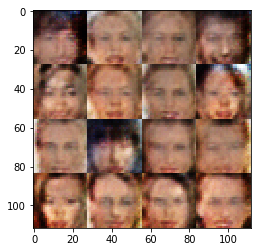

Step 1250/1... Discriminator Loss: 1.3490... Generator Loss: 0.6837
Step 1300/1... Discriminator Loss: 1.2619... Generator Loss: 0.9105


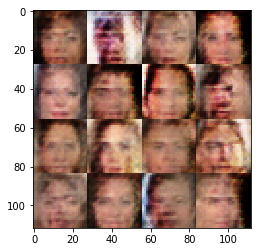

Step 1350/1... Discriminator Loss: 1.3609... Generator Loss: 0.7926
Step 1400/1... Discriminator Loss: 1.2762... Generator Loss: 0.8831


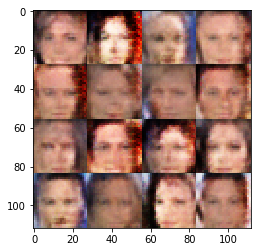

Step 1450/1... Discriminator Loss: 1.3779... Generator Loss: 0.6824
Step 1500/1... Discriminator Loss: 1.3097... Generator Loss: 0.7742


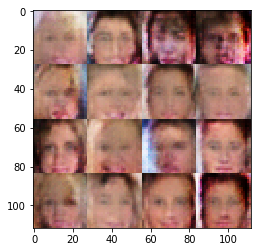

Step 1550/1... Discriminator Loss: 1.4695... Generator Loss: 1.5853


In [42]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005#0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.